In [13]:
from __future__ import print_function

import numpy as np
import torch
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit
import cv2

In [14]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], ".."))
import common

In [15]:
TRT_LOGGER = trt.Logger()

def get_engine(onnx_file_path, engine_file_path=""):
    """Attempts to load a serialized engine if available, otherwise builds a new TensorRT engine and saves it."""
    def build_engine():
        """Takes an ONNX file and creates a TensorRT engine to run inference with"""
        with trt.Builder(TRT_LOGGER) as builder, builder.create_network(common.EXPLICIT_BATCH) as network, trt.OnnxParser(network, TRT_LOGGER) as parser:
            builder.max_workspace_size = 1 << 28 # 256MiB
            builder.max_batch_size = 1
            builder.fp16_mode = True
            # Parse model file
            if not os.path.exists(onnx_file_path):
                print('ONNX file {} not found, please run yolov3_to_onnx.py first to generate it.'.format(onnx_file_path))
                exit(0)
            print('Loading ONNX file from path {}...'.format(onnx_file_path))
            with open(onnx_file_path, 'rb') as model:
                print('Beginning ONNX file parsing')
                if not parser.parse(model.read()):
                    print ('ERROR: Failed to parse the ONNX file.')
                    for error in range(parser.num_errors):
                        print (parser.get_error(error))
                    return None
            # The actual yolov3.onnx is generated with batch size 64. Reshape input to batch size 1
            network.get_input(0).shape = [1, 3, 160, 320]
            print('Completed parsing of ONNX file')
            print('Building an engine from file {}; this may take a while...'.format(onnx_file_path))
            engine = builder.build_cuda_engine(network)
            print("Completed creating Engine")
            with open(engine_file_path, "wb") as f:
                f.write(engine.serialize())
            return engine

    if os.path.exists(engine_file_path):
        # If a serialized engine exists, use it instead of building an engine.
        print("Reading engine from file {}".format(engine_file_path))
        with open(engine_file_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
            return runtime.deserialize_cuda_engine(f.read())
    else:
        return build_engine()


In [16]:
onnx_file_path = '/models/run11/jetracer.onnx'
engine_file_path = '/models/run11/jetracer.trt'
ino = 378
    # Do inference with TensorRT
trt_outputs = []
with get_engine(onnx_file_path, engine_file_path) as engine, engine.create_execution_context() as context:
        inputs, outputs, bindings, stream = common.allocate_buffers(engine)
        # Do inference
        print('Running inference on image')
        # Set host input to the image. The common.do_inference function will copy the input to the GPU before executing.
        image = cv2.imread(f'/models/train_data/Images/{ino:03d}.jpg')
        image = cv2.resize(image,None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA).transpose(2,0,1).reshape(1,3,160,320)
        inputs[0].host = np.array(image, dtype=np.float32, order='C')/255
        trt_outputs = common.do_inference_v2(context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)


Loading ONNX file from path /models/run11/jetracer.onnx...
Beginning ONNX file parsing
Completed parsing of ONNX file
Building an engine from file /models/run11/jetracer.onnx; this may take a while...
Completed creating Engine
Running inference on image


(array([4.3783e+04, 9.7000e+01, 6.5000e+01, 4.4000e+01, 4.2000e+01,
        5.6000e+01, 3.2000e+01, 5.9000e+01, 7.1000e+01, 6.9510e+03]),
 array([0.00102421, 0.10091852, 0.20081283, 0.30070713, 0.40060145,
        0.5004958 , 0.6003901 , 0.7002844 , 0.8001787 , 0.90007305,
        0.99996734], dtype=float32),
 <BarContainer object of 10 artists>)

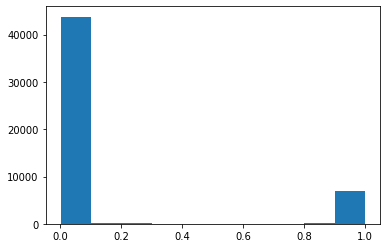

In [17]:
import matplotlib.pyplot as plt
plt.hist(trt_outputs[0])

In [18]:
trt_outputs[0].shape

(51200,)

In [19]:
flat = (trt_outputs[0] > 0.4).astype(np.uint8)

(array([161290.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  43510.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

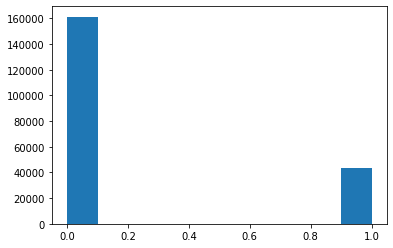

In [10]:
plt.hist(flat)

In [20]:
im3 = flat.reshape (160,320)

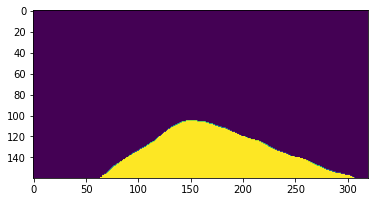

In [21]:
plt.imshow(im3)

In [13]:
mask = trt_outputs[0].reshape(320,640)
output = (mask > 0.7).astype(np.uint8)
im = np.squeeze(image)
im2 = im.transpose(1,2,0)

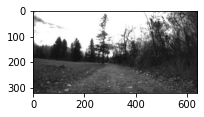

In [14]:
plt.figure(figsize=(10,8))    
plt.subplot(1, 3, 1)
plt.imshow(im2)


In [15]:
image99 = cv2.imread(f'/models/train_data/Images/{ino:03d}.jpg')

In [16]:
image99.shape

(320, 640, 3)

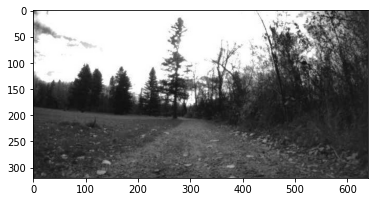

In [17]:
plt.imshow(image99)